# Survival Analysis: the Proportional Hazards Model

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored

In [297]:
training_data_imputed_df = pd.read_csv("training_data_imputed_simple_TRAIN.csv.gz") 
# Filter to 30 day window
survival_data_30d = training_data_imputed_df.loc[
    (training_data_imputed_df['survival_time'] < 30) &
    (training_data_imputed_df['survival_time'] > 0)
    ]
survival_data_30d = survival_data_30d.astype({"cdiff_survival_flag": bool})


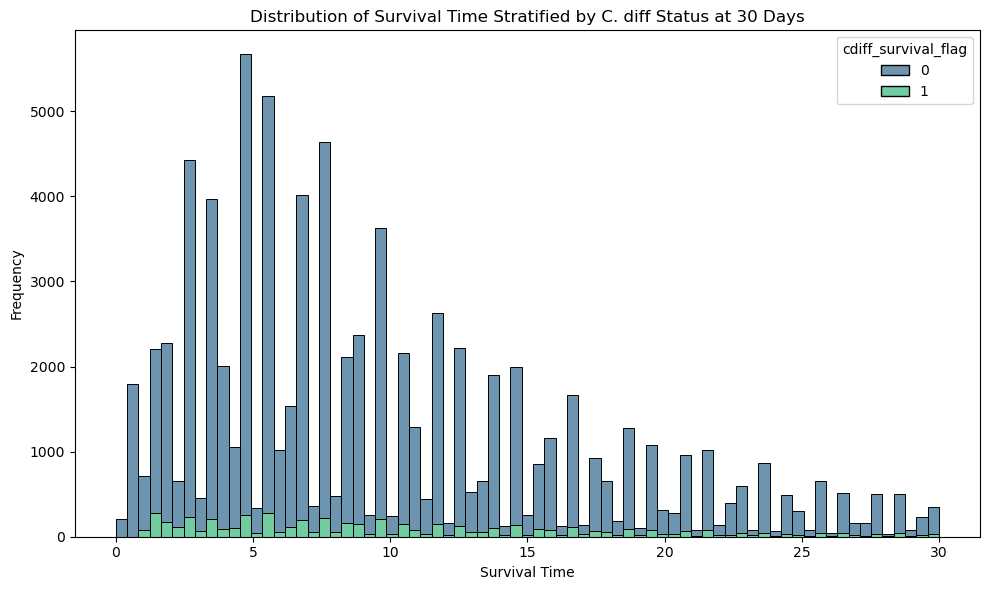

In [ ]:
plt.figure(figsize=(10, 6))
labels = ['No C. diff (0)', 'C. diff present (1)']
sns.histplot(
    data=survival_data_30d,
    x='survival_time',
    hue='cdiff_survival_flag',
    multiple='stack',
    palette='viridis',
    alpha=0.7,
    kde=False,
    hue_order=[0, 1]
)

plt.title('Distribution of Survival Time Stratified by C. diff Status at 30 Days')
plt.xlabel('Survival Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [259]:
survival_data_select = survival_data_30d[
    [col for col in survival_data_30d.columns if '_is_' in col or 'mean_' in col or col in ['admin_time_since_admission', 'admission_time_of_day', 'age_at_admin', 'cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'cdiff_survival_flag', 'survival_time']]]
# survival_data_select = survival_data_30d
survival_data_select  
    # [col for col in survival_data_30d.columns
    #  if '_is_' in col or 'mean_' in col or 'sd_' in col or 'admin' in col or 'admission' in col or col in ['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'cdiff_survival_flag', 'survival_time']]
    #  ]

,ab_class_is_Fluoroquinolone,ab_class_is_Lincosamide,ab_class_is_Nitroimidazole,ab_class_is_Carbapenem,ab_class_is_Aminoglycoside,ab_class_is_Glycopeptide,ab_class_is_Cephalosporin,ab_class_is_Oxazolidinone,ab_class_is_Macrolide,ab_class_is_Lipopeptide,...,mean_platelets,mean_white_blood_cells,age_at_admin,admin_time_since_admission,admission_time_of_day,cdiff_2d_flag,cdiff_7d_flag,cdiff_30d_flag,cdiff_survival_flag,survival_time
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,76.285714,7.35,55.156164,312.0,15.0,0.0,0.0,0.0,False,24.875000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,50.156164,240.0,19.0,0.0,0.0,0.0,False,9.781250
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,81.361644,48.0,21.0,0.0,0.0,0.0,False,18.760417
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,68.605479,288.0,22.0,0.0,0.0,0.0,False,4.791667
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,80.076712,0.0,18.0,0.0,0.0,0.0,False,10.704861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90315,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,82.589041,24.0,5.0,0.0,0.0,0.0,False,8.774306
90316,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,70.000000,7.35,41.512329,1440.0,20.0,0.0,0.0,0.0,False,10.750000
90317,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,70.000000,7.35,68.306849,0.0,7.0,0.0,0.0,0.0,False,17.468056
90318,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,69.435616,48.0,12.0,0.0,0.0,0.0,False,15.583333


In [260]:
train_df, val_df = train_test_split(survival_data_select, test_size=0.2, random_state=1)

In [261]:
X_train = train_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'cdiff_survival_flag', 'survival_time'], axis=1)
y_train = train_df[['cdiff_survival_flag', 'survival_time']]
X_val = val_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'cdiff_survival_flag', 'survival_time'], axis=1)
y_val = val_df[['cdiff_survival_flag', 'survival_time']]

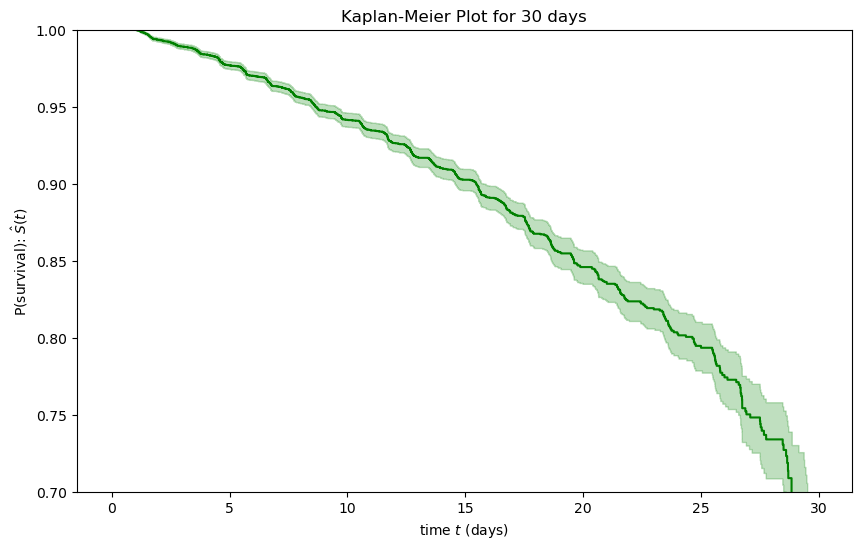

In [296]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    y_val['cdiff_survival_flag'], y_val['survival_time'], conf_type="log-log"
)
plt.figure(figsize=(10, 6))
plt.step(time, survival_prob, color = "green")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post", color = "green")
plt.ylim(0.7, 1)
plt.title("Kaplan-Meier Plot for 30 days")
plt.ylabel(r"P(survival): $\hat{S}(t)$")
plt.xlabel("time $t$ (days)")
plt.show()

In [263]:
y_array_event_time = np.array(
    list(zip(y_train['cdiff_survival_flag'], y_train['survival_time'])), 
    dtype=[('status', bool), ('survival_in_days', float)]
)

In [264]:
cox_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('cox', CoxPHSurvivalAnalysis())
])

# Train the Cox model
cox_pipe.fit(X_train, y_array_event_time)

/opt/miniconda3/envs/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.6558e-18): result may not be accurate.
  delta = solve(
/opt/miniconda3/envs/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.66209e-17): result may not be accurate.
  delta = solve(
/opt/miniconda3/envs/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.62641e-17): result may not be accurate.
  delta = solve(
/opt/miniconda3/envs/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.63675e-17): result may not be accurate.
  delta = solve(
/opt/miniconda3/envs/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.36264e-17): result may not be accurate.
  delta = solve(
/opt/miniconda3/envs/ml4h/lib/python

Pipeline(steps=[('scaler', StandardScaler()), ('cox', CoxPHSurvivalAnalysis())])

In [305]:
cox_pred = cox_pipe.predict(X_val)
cox_cindex_test = concordance_index_censored(
    y_val['cdiff_survival_flag'], y_val['survival_time'], cox_pred
)[0]
print(f"Cox model concordance index: {cox_cindex_test:.4f}")

Cox model concordance index: 0.6482


In [273]:
# if hasattr(cox_pipe.named_steps['cox'], 'coef_'):
coef = pd.Series(cox_pipe.named_steps['cox'].coef_, index=X_train.columns)
hazard_ratios = np.exp(coef)
sorted_hrs = hazard_ratios.sort_values(ascending=False)

hrs_df = pd.DataFrame({'feature':sorted_hrs.index, 'hazard_ratio':sorted_hrs.values})
hrs_df

,feature,hazard_ratio
0,admit_is_EMERGENCY,7.618231
1,admit_is_ELECTIVE,5.660523
2,admit_is_URGENT,2.197021
3,age_at_admin,1.268658
4,admin_time_since_admission,1.156837
5,mean_chloride,1.077308
6,mean_creatinine,1.068499
7,mean_alkaline_phosphatase,1.054864
8,mean_hematocrit,1.054422
9,mean_white_blood_cells,1.018415


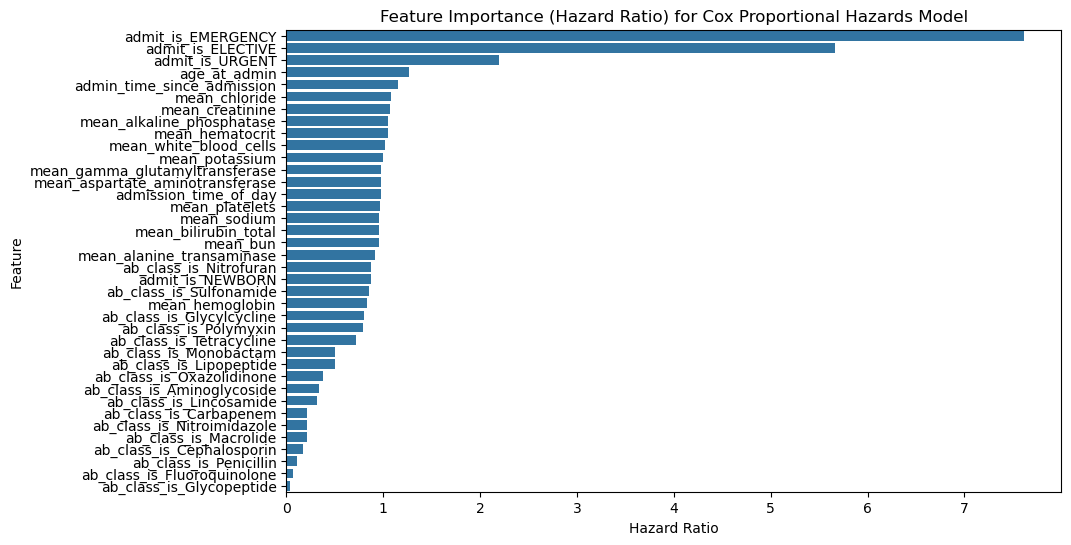

In [295]:
plt.figure(figsize=(10, 6))
# plt.bar(hrs_df['feature'], hrs_df['hazard_ratio'])
sns.barplot(hrs_df, y = 'feature', x = 'hazard_ratio')
plt.title("Feature Importance (Hazard Ratio) for Cox Proportional Hazards Model")
plt.xlabel("Hazard Ratio")
plt.ylabel("Feature")
plt.show()

## Test Evaluation

In [301]:
final_test_df = pd.read_csv("training_data_imputed_simple_TEST.csv.gz")

survival_data_30d_test = final_test_df.loc[
    (training_data_imputed_df['survival_time'] < 30) &
    (training_data_imputed_df['survival_time'] > 0)
    ]
survival_data_30d_test  = survival_data_30d_test.astype({"cdiff_survival_flag": bool})
survival_data_30d_test

,ab_class_is_Fluoroquinolone,ab_class_is_Lincosamide,ab_class_is_Nitroimidazole,ab_class_is_Carbapenem,ab_class_is_Aminoglycoside,ab_class_is_Glycopeptide,ab_class_is_Cephalosporin,ab_class_is_Oxazolidinone,ab_class_is_Macrolide,ab_class_is_Lipopeptide,...,count_platelets,count_white_blood_cells,age_at_admin,admin_time_since_admission,admission_time_of_day,cdiff_2d_flag,cdiff_7d_flag,cdiff_30d_flag,cdiff_survival_flag,survival_time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,1.0,83.835616,24.0,12.0,0.0,0.0,0.0,False,1.000000
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,6.0,1.0,68.024658,408.0,5.0,0.0,0.0,0.0,False,4.649306
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,1.0,26.101370,1128.0,21.0,0.0,0.0,0.0,False,55.432639
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,6.0,1.0,66.397260,120.0,12.0,0.0,0.0,0.0,False,20.581250
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,1.0,74.893151,216.0,22.0,0.0,0.0,0.0,False,8.729167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22575,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,1.0,52.460274,360.0,17.0,0.0,0.0,0.0,False,10.709722
22576,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,6.0,1.0,84.252055,24.0,15.0,0.0,0.0,0.0,False,26.583333
22577,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,6.0,1.0,61.265753,336.0,13.0,0.0,0.0,0.0,False,13.645833
22578,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,1.0,86.531507,0.0,4.0,0.0,0.0,0.0,False,8.700000


In [302]:
survival_data_select_test = survival_data_30d_test[
    [col for col in survival_data_30d_test.columns if '_is_' in col or 'mean_' in col or col in ['admin_time_since_admission', 'admission_time_of_day', 'age_at_admin', 'cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'cdiff_survival_flag', 'survival_time']]]
survival_data_select_test

,ab_class_is_Fluoroquinolone,ab_class_is_Lincosamide,ab_class_is_Nitroimidazole,ab_class_is_Carbapenem,ab_class_is_Aminoglycoside,ab_class_is_Glycopeptide,ab_class_is_Cephalosporin,ab_class_is_Oxazolidinone,ab_class_is_Macrolide,ab_class_is_Lipopeptide,...,mean_platelets,mean_white_blood_cells,age_at_admin,admin_time_since_admission,admission_time_of_day,cdiff_2d_flag,cdiff_7d_flag,cdiff_30d_flag,cdiff_survival_flag,survival_time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,83.835616,24.0,12.0,0.0,0.0,0.0,False,1.000000
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,68.024658,408.0,5.0,0.0,0.0,0.0,False,4.649306
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.482759,7.35,26.101370,1128.0,21.0,0.0,0.0,0.0,False,55.432639
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,66.397260,120.0,12.0,0.0,0.0,0.0,False,20.581250
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,74.893151,216.0,22.0,0.0,0.0,0.0,False,8.729167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22575,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,52.460274,360.0,17.0,0.0,0.0,0.0,False,10.709722
22576,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,70.000000,7.35,84.252055,24.0,15.0,0.0,0.0,0.0,False,26.583333
22577,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,61.265753,336.0,13.0,0.0,0.0,0.0,False,13.645833
22578,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.000000,7.35,86.531507,0.0,4.0,0.0,0.0,0.0,False,8.700000


In [303]:
X_final_test = survival_data_select_test.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'cdiff_survival_flag', 'survival_time'], axis=1)
y_final_test = survival_data_select_test[['cdiff_survival_flag', 'survival_time']]

In [306]:
cox_pred = cox_pipe.predict(X_final_test)
cox_cindex_test = concordance_index_censored(
    y_final_test['cdiff_survival_flag'], y_final_test['survival_time'], cox_pred
)[0]
print(f"Cox model concordance index: {cox_cindex_test:.4f}")

Cox model concordance index: 0.6620
